# 3.X. 1D-CAE Friction Mode


In [1]:
%config InlineBackend.figure_format = "svg"
import numpy as np
from matplotlib import pyplot as plt
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


In [2]:
R = 6.35 / 2
Rg = R * 1.08
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
mu = 0.10


In [3]:
n_hoge = 51
n_half = int(n_hoge/2)
x_hoge = np.linspace(-1, 1, n_hoge)
x_mesh, y_mesh = np.meshgrid(x_hoge, x_hoge)
x_mesh = x_mesh.reshape(-1)
y_mesh = y_mesh.reshape(-1)
ratio_mesh = 1 - np.square(x_mesh) - np.square(y_mesh)
ratio_mesh[ratio_mesh<0]=0
ratio_mesh = np.sqrt(ratio_mesh)
ratio_mesh = ratio_mesh / ratio_mesh.sum()

xvw_ball = np.array([ 7.49214529e-01,  1.86156547e+01,  9.44934733e+00,  7.47973408e+01, -4.44066650e+02,  8.74837953e+02, -3.34519496e+02, -1.05000027e+02, -2.09607491e+01])


In [4]:
def Make_Matrix(a, b):
    return a.reshape(-1, 1) @ b.reshape(1, -1)

def vFmTI_ball(xvw_ball, t, mode):
    
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    
    Zeros = np.zeros(3)
    vr = np.linalg.norm(v_ball)
    x_square = np.square(x_mesh)
    y_square = np.square(y_mesh)
    
    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()
    
    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    v_eta = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])
    
    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])
    
    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
                F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

                a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])
                
                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
                
                p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(0.5 * np.square(a_[iSP,i]) * x_square / R + 0.5 * np.square(b_[iSP,i]) * y_square / R, -exyz[iSP,i,:])
                F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh
                
                SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
                v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)
                
    Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
    TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
    
    if mode == 1:
        return a_, b_, a_dir, b_dir, dv

    if mode == 2:
        return a_, b_, a_dir, b_dir, muF, F_norm
    
    if mode == 3:
        return v_eta
    
    return np.concatenate([v_ball, Fm_ball, TI_ball])



In [5]:
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

def plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, dv_unit):
    # Defining subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 4), dpi=300)

    # Creating plot
    a_max = a_.max()
    b_max = b_.max()

    for iSP in range(2):
        for i in range(2):
            a_mesh00 = a_[iSP,i] * x_mesh
            b_mesh00 = b_[iSP,i] * y_mesh

            dvx00 = dv[iSP,i,:,:].dot(a_dir[iSP,i,:])
            dvy00 = dv[iSP,i,:,:].dot(b_dir[iSP,:])

            dv_norm = np.sqrt(np.square(dvx00) + np.square(dvy00))

            ellipse = Ellipse(xy=(0.0, 0.0), width=2*a_[iSP,i], height=2*b_[iSP,i], edgecolor='k', fc='None')
            quiver = ax[iSP, i].quiver(a_mesh00, b_mesh00, dvx00, dvy00, dv_norm, cmap='jet')
            ax[iSP, i].add_patch(ellipse)
            ax[iSP, i].set_aspect('equal')
            ax[iSP, i].axis([-a_max, a_max, -b_max, b_max])
            ax[iSP, i].spines['right'].set_visible(False)
            ax[iSP, i].spines['top'].set_visible(False)
            ax[iSP, i].spines['left'].set_visible(False)
            ax[iSP, i].spines['bottom'].set_visible(False)
            ax[iSP, i].yaxis.set_ticks([])
            ax[iSP, i].set_xlabel('x [mm]')
            colorbar = fig.colorbar(quiver, ax=ax[iSP, i])
            colorbar.ax.set_title(dv_unit)
            
    return fig, ax


In [6]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(xvw_ball, 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


In [7]:
a_, b_, a_dir, b_dir, dv = vFmTI_ball(xvw_ball, 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


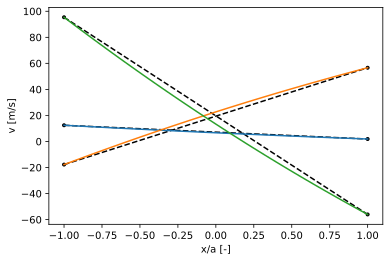

In [8]:
plt.plot(x_mesh[10*n_hoge:11*n_hoge:n_hoge-1], dv[0, 0, 10*n_hoge:11*n_hoge:n_hoge-1], 'k.--')
plt.plot(x_mesh[10*n_hoge:11*n_hoge:], dv[0, 0, 10*n_hoge:11*n_hoge:])
plt.xlabel('x/a [-]')
plt.ylabel('v [m/s]')
plt.show()


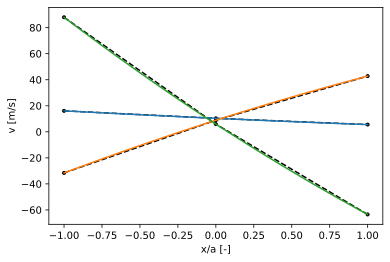

In [9]:
plt.plot(x_mesh[n_half*n_hoge:(n_half+1)*n_hoge:n_half], dv[0, 0, n_half*n_hoge:(n_half+1)*n_hoge:n_half], 'k.--')
plt.plot(x_mesh[n_half*n_hoge:(n_half+1)*n_hoge:], dv[0, 0, n_half*n_hoge:(n_half+1)*n_hoge:])
plt.xlabel('x/a [-]')
plt.ylabel('v [m/s]')
plt.show()


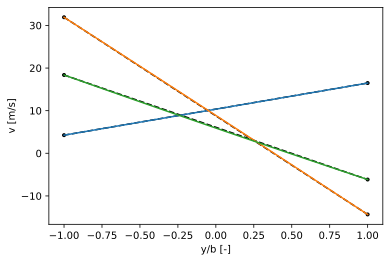

In [10]:
plt.plot(y_mesh[n_half::(2*n_half)*n_hoge], dv[0, 0, n_half::(2*n_half)*n_hoge], 'k.--')
plt.plot(y_mesh[n_half::n_hoge], dv[0, 0, n_half::n_hoge])
plt.xlabel('y/b [-]')
plt.ylabel('v [m/s]')
plt.show()


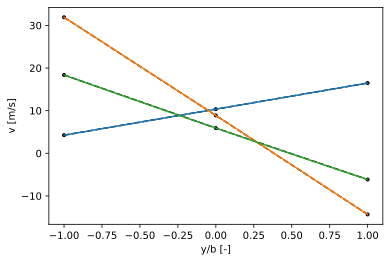

In [11]:
plt.plot(y_mesh[n_half::n_half*n_hoge], dv[0, 0, n_half::n_half*n_hoge], 'k.--')
plt.plot(y_mesh[n_half::n_hoge], dv[0, 0, n_half::n_hoge])
plt.xlabel('y/b [-]')
plt.ylabel('v [m/s]')
plt.show()


$$
\begin{align}
F &= F_{\text{up,right}} + F_{\text{up,left}} + F_{\text{down,left}} + F_{\text{down,right}} \\\\
\Delta u(s, t) &= u_0 + s u_a + t u_b \\\\
P(s, t) &= P_{\text{max}}\sqrt{1-s^2-t^2} \\\\
F_{\text{up,right}}&=\int_{t=0}^{1} \int_{s=0}^{\sqrt{1-t^2}} \frac{\Delta u(s, t)}{|\Delta u(s, t)|} \mu P(s, t) \cdot \text{d}s \text{d}t \\\\
&=\mu P_{\text{max}} \cdot \int_{t=0}^{1} \int_{s=0}^{\sqrt{1-t^2}} \frac{u_0 + s u_a + t u_b}{|u_0 + s u_a + t u_b|} \sqrt{1-s^2-t^2} \cdot \text{d}s \text{d}t \\\\
&=\mu P_{\text{max}} \cdot \int_{t=0}^{1} \int_{s=0}^{\sqrt{1-t^2}} \frac{\left( \begin{array}{c} u_{0x} \\ u_{0y} \\ u_{0z} \end{array} \right) + s \left( \begin{array}{c} u_{ax} \\ u_{ay} \\ u_{az} \end{array} \right) + t \left( \begin{array}{c} u_{bx} \\ u_{by} \\ u_{bz} \end{array} \right)}{\left| \left( \begin{array}{c} u_{0x} \\ u_{0y} \\ u_{0z} \end{array} \right) + s \left( \begin{array}{c} u_{ax} \\ u_{ay} \\ u_{az} \end{array} \right) + t \left( \begin{array}{c} u_{bx} \\ u_{by} \\ u_{bz} \end{array} \right) \right|} \sqrt{1-s^2-t^2} \cdot \text{d}s \text{d}t \\\\
&= ... \\\\
&= \mu P_{\text{max}} \cdot f(u_0, u_a, u_b)\\\\
\end{align}
$$

Can I make it an identity?


In [12]:
n_hoge = 51
x_hoge = np.linspace(0, 1, n_hoge)
x_mesh, y_mesh = np.meshgrid(x_hoge, x_hoge)
x_mesh = x_mesh.reshape(-1)
y_mesh = y_mesh.reshape(-1)
a_, b_, a_dir, b_dir, dv = vFmTI_ball(xvw_ball, 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


In [13]:
P_mesh = 1 - x_mesh**2 - y_mesh**2
P_mesh[P_mesh<0]=0
np.sqrt(P_mesh)
P_mesh = P_mesh / P_mesh.sum()

u0 = dv[0,0,0]
ux = dv[0,0,n_hoge-1] - u0
uy = dv[0,0,n_hoge*(n_hoge-1)] - u0

u_mesh = u0 + Make_Matrix(x_mesh, ux) + Make_Matrix(y_mesh, uy)


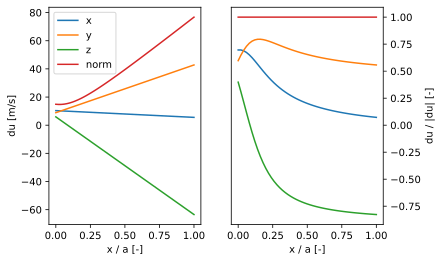

In [14]:
u_norm = np.sqrt(np.square(u_mesh).sum(1)).reshape([-1,1])
u_dir = u_mesh / u_norm

fig, ax = plt.subplots(1, 2)
ax[0].plot(x_mesh[:n_hoge], u_mesh[:n_hoge])
ax[0].plot(x_mesh[:n_hoge], u_norm[:n_hoge])
ax[0].set_xlabel('x / a [-]')
ax[0].set_ylabel('du [m/s]')
ax[0].legend(['x', 'y', 'z', 'norm'])
ax[1].plot(x_mesh[:n_hoge], u_dir[:n_hoge])
ax[1].plot(x_mesh[:n_hoge], np.ones(x_mesh[:n_hoge].shape))
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_xlabel('x / a [-]')
ax[1].set_ylabel('du / |du| [-]')
plt.show()


In [15]:
F = (u_dir * P_mesh.reshape([-1,1])).sum(0)
